#### 테마주 목록 로드

In [40]:
from utils import *

In [2]:
import os
import ta
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import matplotlib

import pickle
from tqdm import tqdm

In [8]:
# 전체 상장주 가져오기
krx_list = get_KRX_list()
krx_list

,Code,Name
0,005930,삼성전자
1,373220,LG에너지솔루션
2,000660,SK하이닉스
3,207940,삼성바이오로직스
4,005935,삼성전자우
...,...,...
1699,413600,키움제6호스팩
1700,457940,에스케이증권제10호스팩
1701,373340,유진스팩6호
1702,032685,소프트센우


In [9]:
# 네이버 증권 테마주 가져오기
themed_list = pd.read_csv('./themed_stocks_with_code_no_dup.csv', index_col=0, encoding='UTF-8', dtype={'Code': str})
themed_list

,Theme,Name,Code
0,화이자(PFIZER),제주반도체,80220
1,화이자(PFIZER),대한약품,23910
2,화이자(PFIZER),유한양행,100
3,화이자(PFIZER),파미셀,5690
4,화이자(PFIZER),제일약품,271980
...,...,...,...
5026,면세점,호텔신라,8770
5027,면세점,JTC,950170
5028,면세점,신세계,4170
5029,면세점,현대백화점,69960


In [38]:
# 학습시킬 테마주 선택
themes = themed_list['Theme'].unique().tolist()

theme_stock_dict = dict()
to_clustering = list()

for theme in themes:
    curr_themes = themed_list[themed_list['Theme'] == theme]['Name']
    if len(curr_themes) <= 20:
        continue
    theme_stock_dict[theme] = curr_themes
    to_clustering = to_clustering + curr_themes.to_list()
    
for key, val in theme_stock_dict.items():
    print(key, len(val))
    
print("테마 개수", len(theme_stock_dict.keys()))

print("to_clustering", len(to_clustering))


# 딕셔너리의 키와 값의 길이로 데이터프레임 생성
themed_stock_base = pd.DataFrame([(key, len(val)) for key, val in theme_stock_dict.items()], columns=['Theme', 'Length'])
themed_stock_base.to_csv('themed_stock_dict.csv', index=False, encoding='UTF-8')

# 리스트를 Pandas Series로 변환
data_series = pd.Series(to_clustering, name='Name')  # 'Column_Name'은 열의 이름입니다.

# Series를 CSV 파일로 저장
csv_file_path = 'themed_stock_list.csv'
data_series.to_csv(csv_file_path, index=False, encoding='UTF-8')

print(f"Data has been saved to {csv_file_path}")

# themed_stock_df = pd.DataFrame(to_clustering)
# themed_stock_df.to_csv("themed_stock_list.csv", encoding='UTF-8', index=False)


UAM(도심항공모빌리티) 23
영상콘텐츠 32
광고 21
지능형로봇/인공지능(AI) 45
메타버스(Metaverse) 26
방위산업/전쟁 및 테러 28
로봇(산업용/협동로봇 등) 27
자율주행차 22
5G(5세대 이동통신) 35
LCD장비 34
2021 상반기 신규상장 33
스마트폰 41
시스템반도체 29
보안주(정보) 30
2023 상반기 신규상장 39
2021 하반기 신규상장 43
OLED(유기 발광 다이오드) 28
건설 중소형 28
유전자 치료제/분석 24
2023 하반기 신규상장 48
화장품 63
전기차 45
2022 하반기 신규상장 54
반도체 장비 28
음식료업종 49
2019 하반기 신규상장 25
자동차부품 70
2차전지 24
2020 하반기 신규상장 31
치매 25
지주사 68
아프리카 돼지열병(ASF) 21
테마 개수 32
to_clustering 1139
Data has been saved to themed_stock_list.csv


#### 주식이 20개 이상 있는 각 테마들의 클러스터링

In [45]:
themes_more_than_20_stocks = pd.read_csv('themed_stock_dict.csv', encoding='UTF-8')['Theme'].to_list()
print(themes_more_than_20_stocks[:16])
print(themes_more_than_20_stocks[16:])

['UAM(도심항공모빌리티)', '영상콘텐츠', '광고', '지능형로봇/인공지능(AI)', '메타버스(Metaverse)', '방위산업/전쟁 및 테러', '로봇(산업용/협동로봇 등)', '자율주행차', '5G(5세대 이동통신)', 'LCD장비', '2021 상반기 신규상장', '스마트폰', '시스템반도체', '보안주(정보)', '2023 상반기 신규상장', '2021 하반기 신규상장']
['OLED(유기 발광 다이오드)', '건설 중소형', '유전자 치료제/분석', '2023 하반기 신규상장', '화장품', '전기차', '2022 하반기 신규상장', '반도체 장비', '음식료업종', '2019 하반기 신규상장', '자동차부품', '2차전지', '2020 하반기 신규상장', '치매', '지주사', '아프리카 돼지열병(ASF)']


In [51]:
def visualize_clusters_local(df, labels, name):
      
    fig, ax = plt.subplots()
    sc = ax.scatter(df.iloc[:, 0], df.iloc[:, 1], cmap='rainbow')
    plt.title('Cluster')
    plt.xlabel('Mean Return')
    plt.ylabel('Volatility')

    # legend : Cluster labels 
    ax.legend(*sc.legend_elements(), title='clusters')
    plt.colorbar(sc) # 오르쪽 컬러바

    # n개 미만일 경우 회사명 명시
    # if df.shape[0] < 100000:
    #     for x, y, name in zip(df.iloc[:, 0], df.iloc[:, 1], df.index):
    #         label = name
    #         plt.annotate(label, # this is the text
    #                     (x,y), # this is the point to label
    #                     textcoords="offset points", # how to position the text
    #                     xytext=(0,10), # distance from text to points (x,y)
    #                     ha='center', # horizontal alignment can be left, right or center
    #                     alpha=0.5) 
    plt.savefig(f'./theme_stock_clusters/{name}.png')
    plt.show()

In [52]:
def clustering_and_visualize(in_list, name):
    # stock Code, Name 추출
    df = pd.DataFrame(krx_list)
    stock_list = df[df['Name'].isin(in_list)]

    # 데이터 기간 설정
    start_date, end_date = '20230101', '20231206'

    # 실행
    df = get_cluster_labels_dataset(stock_list, start_date, end_date)
    # print(df)

    # 저장
    df.to_csv(f'./theme_stock_clusters/{name}.csv', index=False, encoding='UTF-8')

    # 시각화
    visualize_clusters_local(df, df['Cluster'].to_numpy(), name)

In [49]:
# 'UAM(도심항공모빌리티)'
theme1 = theme_stock_dict['UAM(도심항공모빌리티)'].reset_index(drop=True)
print("numbers of theme1:", len(theme1))
print(theme1)
theme1 = theme1.to_list()

numbers of theme1: 23
0         LIG넥스원
1             남성
2          한화시스템
3     켄코아에어로스페이스
4            퍼스텍
5             KT
6          넥센타이어
7          파이버프로
8            카카오
9           제주항공
10        한국항공우주
11         기산텔레콤
12          네온테크
13     한화에어로스페이스
14         하이즈항공
15          서연이화
16            GS
17          한국카본
18        LG유플러스
19         SK텔레콤
20          대한항공
21           현대차
22          현대건설
Name: Name, dtype: object


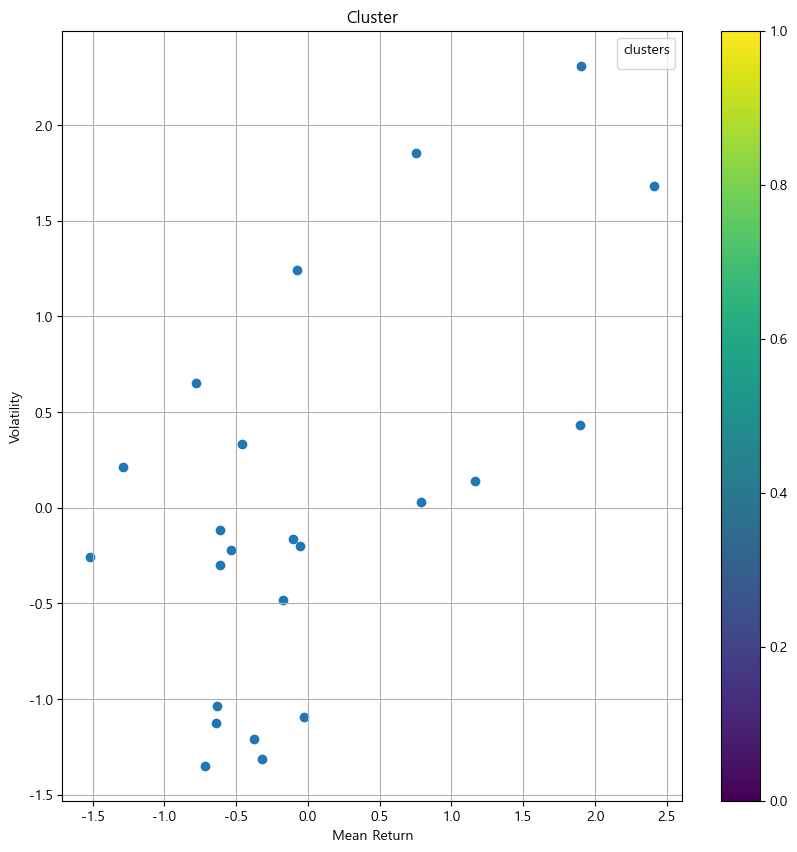

In [53]:
clustering_and_visualize(theme1, 'UAM(도심항공모빌리티)')